# EMBS-BHI-2025: Robust and Reproducible AI Tutorial

Tutorial instructors: Ernest Namdar and Pascal Tyrrell

The dataset used in this tutorial and some of the codes are adopted from Openradiomics.
https://pubmed.ncbi.nlm.nih.gov/40760408/

This notebook uses radiomics-based binary classification and compares several resampling strategies using a Random Forest.

## Setup
We start by importing the Python packages used throughout the tutorial and setting a deterministic seed.
Directory structure of the projects is another crucial factor that helps reproducibility.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    RepeatedStratifiedKFold, StratifiedKFold, StratifiedShuffleSplit
)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from joblib import Parallel, delayed

SEED = 0
REPEATS = 100
N_JOBS = -1  # use all available CPU cores

np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
# Comment out this cell if you run the code locally
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- Set working directory ---
import os

project_path = '/content/drive/MyDrive/EMBS_BHI_2025_Tutorial_Robust_and_Reproducible_AI/Part1-Classification/code'

# Change the working directory
os.chdir(project_path)

# Verify
print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/EMBS_BHI_2025_Tutorial_Robust_and_Reproducible_AI/Part1-Classification/code


## Load and Prepare the Dataset
The dataset ships with this tutorial under `../data/`. We remove metadata columns and focus on the radiomic features while binarizing the labels.

In [3]:
DATA_PATH = '../data/Radiomics_NoNormalization_Whole_Tumor_T1CE.csv'

df = pd.read_csv(DATA_PATH)

In [4]:
df

,Lesion_ID,Group,Group_label,Patient_ID,Normalization,Subregion,Sequence,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,...,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength
0,1,LGG,0,BraTS20_Training_264,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,257.875481,0.002917,7.129410,0.068842,1.065569e+04,1.857225,0.001056,402.594060,0.057651,0.400334
1,2,LGG,0,BraTS20_Training_333,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,31400.796681,0.000034,9.194488,0.550131,5.733321e+00,0.037253,0.000198,615308.179535,0.086944,37.474497
2,3,LGG,0,BraTS20_Training_290,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,687.290391,0.001712,7.892693,0.031033,4.019240e+05,1.891263,0.000142,1546.563118,0.005046,0.767814
3,4,LGG,0,BraTS20_Training_269,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,14.038038,0.055507,5.427283,0.004712,1.996953e+06,34.988012,0.000462,11.145451,0.005164,0.024456
4,5,LGG,0,BraTS20_Training_263,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,799.617583,0.000725,7.988775,0.117867,5.486999e+03,0.454818,0.000960,2447.225716,0.047115,3.002776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,365,HGG,1,BraTS20_Training_207,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,250.731263,0.003331,7.412216,0.055957,3.441931e+04,2.054098,0.000544,586.352427,0.032293,0.458392
365,366,HGG,1,BraTS20_Training_192,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,994.351189,0.001169,7.464253,0.117230,3.670582e+04,2.321920,0.000186,2915.452880,0.036619,0.935791
366,367,HGG,1,BraTS20_Training_007,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,1122.955449,0.001012,7.625789,0.249371,2.043887e+03,0.674250,0.000442,8412.504297,0.069797,2.593628
367,368,HGG,1,BraTS20_Training_235,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,2511.604246,0.000511,8.163777,0.277927,3.428665e+03,1.032603,0.000163,17448.583739,0.088018,1.784128


In [5]:
y = df['Group_label']
X = df.drop(columns=[
    'Lesion_ID', 'Group', 'Group_label', 'Patient_ID',
    'Normalization', 'Subregion', 'Sequence'
] + [col for col in df.columns if col.startswith('diag')])

lb = LabelBinarizer()
y_bin = lb.fit_transform(y).ravel()

X.shape, y.shape

((369, 1688), (369,))

There are 369 patients in the dataset (BraTS 2020) and 1688 radiomics features were extracted for each patient.

## Helper Functions
`fit_and_score` trains a Random Forest on the provided split and returns AUROC.

In [6]:
def fit_and_score(train_idx, test_idx):
    clf = RandomForestClassifier(random_state=SEED)
    clf.fit(X.iloc[train_idx], y_bin[train_idx])
    prob = clf.predict_proba(X.iloc[test_idx])[:, 1]
    return roc_auc_score(y_bin[test_idx], prob)

## Cross-Validation Strategies
We evaluate repeated and single-run stratified folds, repeated shuffle split, and leave-one-out cross-validation. Parallelization shortens execution time but the notebook may still take a few minutes to finish.

In [7]:
rskf_4 = RepeatedStratifiedKFold(n_splits=4, n_repeats=REPEATS, random_state=SEED)
scores_rep4 = Parallel(n_jobs=N_JOBS)(
    delayed(fit_and_score)(train, test) for train, test in rskf_4.split(X, y_bin)
)

skf_4 = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)
scores_1x4 = [fit_and_score(train, test) for train, test in skf_4.split(X, y_bin)]

skf_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scores_1x5 = [fit_and_score(train, test) for train, test in skf_5.split(X, y_bin)]

skf_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
scores_1x10 = [fit_and_score(train, test) for train, test in skf_10.split(X, y_bin)]

sss = StratifiedShuffleSplit(n_splits=REPEATS, test_size=0.25, random_state=SEED)
scores_sss = Parallel(n_jobs=N_JOBS)(
    delayed(fit_and_score)(train, test) for train, test in sss.split(X, y_bin)
)

def loo_predict(i):
    train_idx = np.delete(np.arange(len(X)), i)
    test_idx = np.array([i])
    clf = RandomForestClassifier(random_state=SEED)
    clf.fit(X.iloc[train_idx], y_bin[train_idx])
    return clf.predict_proba(X.iloc[test_idx])[0, 1]

print('Running LOO predictions (this may take a while)...')
y_probs_loo = Parallel(n_jobs=N_JOBS)(delayed(loo_predict)(i) for i in range(len(X)))
auc_loo = roc_auc_score(y_bin, y_probs_loo)
scores_loo = [auc_loo] * REPEATS

methods = [
    ('Repeated 4-Fold', scores_rep4),
    ('One-time 4-Fold', scores_1x4),
    ('One-time 5-Fold', scores_1x5),
    ('One-time 10-Fold', scores_1x10),
    ('Repeated 75/25 Split', scores_sss),
    ('LOO CV', scores_loo),
]

methods

Running LOO predictions (this may take a while)...


[('Repeated 4-Fold',
  [np.float64(0.9445234708392605),
   np.float64(0.9513338139870224),
   np.float64(0.8857245854361933),
   np.float64(0.9333093006488825),
   np.float64(0.9637268847795163),
   np.float64(0.893294881038212),
   np.float64(0.9837779379956741),
   np.float64(0.8745493871665465),
   np.float64(0.9939544807965861),
   np.float64(0.9372746935832732),
   np.float64(0.8071377072819034),
   np.float64(0.9614275414563807),
   np.float64(0.9395448079658606),
   np.float64(0.9675558759913483),
   np.float64(0.932588320115357),
   np.float64(0.9084354722422495),
   np.float64(0.9320768136557611),
   np.float64(0.9567411679884643),
   np.float64(0.9142033165104542),
   np.float64(0.9250180245133381),
   np.float64(0.9217638691322902),
   np.float64(0.9358327325162221),
   np.float64(0.9397981254506128),
   np.float64(0.8918529199711609),
   np.float64(0.9708392603129445),
   np.float64(0.9026676279740448),
   np.float64(0.9603460706560922),
   np.float64(0.912761355443403),
  

## Visualize Results
The box plot highlights the distribution of AUROCs for each strategy.

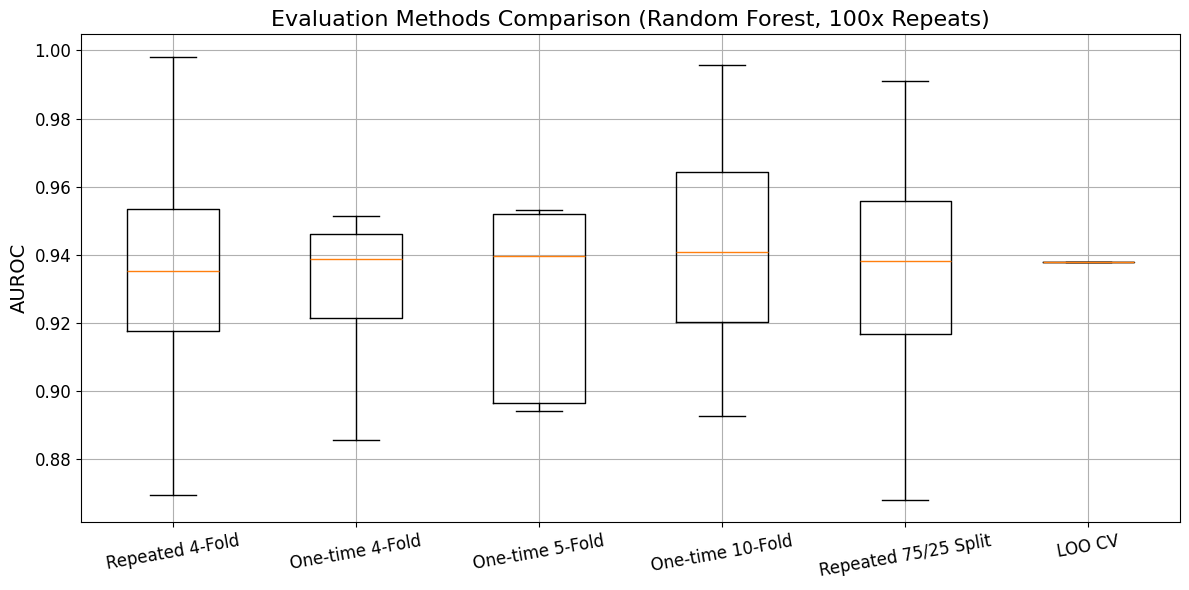

In [8]:
plt.figure(figsize=(12, 6))
plt.boxplot(
    [scores for _, scores in methods],
    tick_labels=[name for name, _ in methods],
    showfliers=False
)
plt.ylabel('AUROC', fontsize=14)
plt.title('Evaluation Methods Comparison (Random Forest, 100x Repeats)', fontsize=16)
plt.xticks(fontsize=12, rotation=10)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary Statistics
For quick comparison we display mean and standard deviation of AUROC per method.

In [9]:
import numpy as np
for name, scores in methods:
    print(f'{name}: Mean AUC = {np.mean(scores):.4f} ± {np.std(scores):.4f}')

Repeated 4-Fold: Mean AUC = 0.9348 ± 0.0270
One-time 4-Fold: Mean AUC = 0.9287 ± 0.0256
One-time 5-Fold: Mean AUC = 0.9271 ± 0.0263
One-time 10-Fold: Mean AUC = 0.9425 ± 0.0297
Repeated 75/25 Split: Mean AUC = 0.9354 ± 0.0289
LOO CV: Mean AUC = 0.9378 ± 0.0000
